# Use Case 5: Gene set enrichment analysis

## Step 1: Importing packages and setting up your notebook.

We start the notebook by importing the standard packages for data science. These are useful for playing data in dataframes and for plotting the results.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import gseapy as gp
from gseapy.plot import barplot, dotplot

Our cancer data and a variety of accessory functions are provided in the CPTAC package.

In [12]:
import CPTAC

## Step 2: Getting data

We begin by retrieving the clinical and proteomics dataframes utilizing the <code>CPTAC.get_clinical()</code> and <code>CPTAC.get_proteomics()</code> functions.

In [3]:
clinical = CPTAC.get_clinical()
proteomics = CPTAC.get_proteomics()

## Step 3: Merging dataframes

For this example we will be separating the protein abudance based on the clinical MSI (microsatellite instability). We first combine the MSI information into the proteomics dataframe utilizing the <code>CPTAC.compare_clinical()</code> function.

In [4]:
msiProt = CPTAC.compare_clinical(proteomics, 'MSI')

## Step 4: Organizing the data

We then separate the proteomics into two groups, based on whether the patient is MSI-H (microsatellite instability high) or MSS (microsatellite stable, which we term also as MSI-normal for easy conceptualization of comparison).

In [5]:
#Retrieve boolean array of true values
high = msiProt['MSI'] == "MSI-H"
normal = msiProt['MSI'] != "MSI-H"
#Use boolean array to select for appropriate patients
high_MSI = msiProt[high]
normal_MSI = msiProt[normal]

## Step 5: Perform statistical tests

Next, we find which genes that are upregulated in each partition using Welch's t-test (a variation on the two sample t-test due to different variances between the two groups) to compare the MSI-high individuals with the MSS or MSI-normal individuals for each gene.

In [6]:
#Create array variables to hold the significant genes for each partition
high_MSI_genes = []
normal_MSI_genes = []
#Grab the genes of interest, ignoring the MSI column in the dataframe
genes = high_MSI.columns[1:]
#Correct alpha level for multiple testing by dividing the standard .05 by the number of genes to be analyzed
threshold = .05 / len(genes)
#Perform Welch's t-test(different variances) on each gene between the two groups
for gene in genes:
    high_MSI_gene_abundance = high_MSI[gene]
    normal_MSI_gene_abundance = normal_MSI[gene]
    pvalue = stats.ttest_ind(high_MSI_gene_abundance, normal_MSI_gene_abundance, equal_var = False, nan_policy='omit').pvalue
    #If the P-value is significant, determine which partition is more highly expressed
    if pvalue < threshold:
        if high_MSI_gene_abundance.mean() > normal_MSI_gene_abundance.mean():
            high_MSI_genes.append(gene)
        elif normal_MSI_gene_abundance.mean() > high_MSI_gene_abundance.mean():
            normal_MSI_genes.append(gene)
#Optional check of number of genes in each partition
print("MSI High Genes:", len(high_MSI_genes))
print("MSI Normal Genes:", len(normal_MSI_genes))

MSI High Genes: 122
MSI Normal Genes: 473


## Step 6: Gene set enrichment analysis

We then use the genes that are up-regulated in these partitions to perform a Gene Set Enrichment Analysis using the <code>gp.enrichr()</code> function (<code>gp</code> being the specified abbreviation for the imported gseapy package).

In [7]:
MSI_high_enr = gp.enrichr(gene_list = high_MSI_genes, description='MSI High partition', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.5)
MSI_normal_enr = gp.enrichr(gene_list = normal_MSI_genes, description='MSI Normal partition', gene_sets='KEGG_2016', outdir='test/enrichr_kegg',cutoff=.5)

We can view the data as a table by using the <code>obj.res2d</code> command (<code>obj</code> being the variable name specified in the previous step). The Gene Set Enrichment Analysis returns a list of pathways the genes provided are involved in, based on a significant adjusted P-value.

In [8]:
MSI_high_enr.res2d

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes,Gene_set
0,Amino sugar and nucleotide sugar metabolism_Ho...,4/48,0.000208,0.011698,0.000722,0.035782,-1.858650,15.754145,UGDH;GFPT1;GNPNAT1;UAP1,KEGG_2016
1,Tight junction_Homo sapiens_hsa04530,6/139,0.000211,0.011698,0.000939,0.035782,-1.673348,14.161257,OCLN;PPP2R1B;CGN;TJP3;TJP2;LLGL2,KEGG_2016
2,Terpenoid backbone biosynthesis_Homo sapiens_h...,3/22,0.000313,0.011698,0.000958,0.035782,-1.604807,12.948000,IDI1;HMGCS1;PDSS2,KEGG_2016
3,Peroxisome_Homo sapiens_hsa04146,4/83,0.001670,0.046770,0.004838,0.135465,-1.628848,10.416009,SCP2;HSD17B4;HACL1;DECR2,KEGG_2016
4,Pyrimidine metabolism_Homo sapiens_hsa00240,4/105,0.003922,0.087845,0.010637,0.198567,-1.680203,9.310407,DTYMK;RRM1;PNP;DCK,KEGG_2016
5,Metabolic pathways_Homo sapiens_hsa01100,14/1239,0.018811,0.263356,0.107871,0.710680,-1.837758,7.301976,IDI1;RRM1;DTYMK;HMGCS1;GFPT1;HSD17B4;UAP1;DCK;...,KEGG_2016
6,Hippo signaling pathway_Homo sapiens_hsa04390,4/153,0.014417,0.230674,0.035281,0.564490,-1.592147,6.749651,PPP2R1B;RASSF6;PPP1CA;LLGL2,KEGG_2016
7,Insulin resistance_Homo sapiens_hsa04931,3/109,0.029134,0.330985,0.058667,0.710680,-1.649440,5.832168,GFPT1;RPS6KA1;PPP1CA,KEGG_2016
8,Oocyte meiosis_Homo sapiens_hsa04114,3/123,0.039525,0.368903,0.077634,0.710680,-1.592321,5.144493,PPP2R1B;RPS6KA1;PPP1CA,KEGG_2016
9,Lysosome_Homo sapiens_hsa04142,3/123,0.039525,0.368903,0.077634,0.710680,-1.523396,4.921811,AP1G2;DNASE2;AP1M2,KEGG_2016


In [9]:
MSI_normal_enr.res2d

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes,Gene_set
0,Focal adhesion_Homo sapiens_hsa04510,36/202,2.006683e-21,3.993300e-19,3.095925e-18,6.160892e-16,-1.922008,91.598663,TNXB;ROCK1;ROCK2;LAMA4;ILK;MYLK;THBS3;AKT3;CAP...,KEGG_2016
1,Proteoglycans in cancer_Homo sapiens_hsa05205,26/203,2.562988e-12,2.550173e-10,1.881598e-10,1.872190e-08,-1.987454,53.044836,ROCK1;ROCK2;HSPB2;ITPR1;CBL;FGF2;RRAS;AKT3;TIM...,KEGG_2016
2,Regulation of actin cytoskeleton_Homo sapiens_...,25/214,5.208207e-11,2.841574e-09,2.476605e-09,1.403552e-07,-1.871449,44.312543,ROCK1;ROCK2;ARPC1A;FGF2;MYLK;RRAS;CFL2;GNA12;P...,KEGG_2016
3,Vascular smooth muscle contraction_Homo sapien...,19/120,5.711707e-11,2.841574e-09,2.821210e-09,1.403552e-07,-1.789354,42.203567,GUCY1A2;PPP1R14A;CALCRL;PPP1R12A;ROCK1;ROCK2;I...,KEGG_2016
4,Bacterial invasion of epithelial cells_Homo sa...,13/78,3.343801e-08,1.330833e-06,5.946168e-07,2.366575e-05,-1.667587,28.705134,SEPT11;CAV1;ARPC1A;GAB1;ILK;CBL;SEPT2;PTK2;SEP...,KEGG_2016
5,Oxytocin signaling pathway_Homo sapiens_hsa04921,17/158,2.181953e-07,7.236810e-06,2.939947e-06,9.750824e-05,-1.840301,28.226306,GUCY1A2;PPP1R12A;ROCK1;ROCK2;CACNA2D1;ITPR1;PR...,KEGG_2016
6,Pathways in cancer_Homo sapiens_hsa05200,27/397,1.008022e-06,2.507455e-05,1.425248e-05,3.151382e-04,-1.922925,26.550831,ROCK1;ROCK2;LAMA4;CBL;FGF2;GNG7;SUFU;AKT3;GNA1...,KEGG_2016
7,Hypertrophic cardiomyopathy (HCM)_Homo sapiens...,12/83,5.636711e-07,1.602436e-05,6.151277e-06,1.748720e-04,-1.654008,23.799187,CACNB3;DES;SGCD;TPM4;SGCB;TPM2;CACNA2D1;MYL3;L...,KEGG_2016
8,Dilated cardiomyopathy_Homo sapiens_hsa05414,12/90,1.372676e-06,3.035140e-05,1.294924e-05,3.151382e-04,-1.654657,22.335800,CACNB3;DES;SGCD;TPM4;SGCB;TPM2;CACNA2D1;MYL3;L...,KEGG_2016
9,PI3K-Akt signaling pathway_Homo sapiens_hsa04151,23/341,7.320533e-06,1.120605e-04,7.366143e-05,1.047045e-03,-1.755919,20.763436,PDGFRB;TNXB;VWF;IRS1;LAMB2;LAMA4;PRKCA;GNG11;F...,KEGG_2016


## Step 7: Plot the p-values

We can better visualize these tables and the significant pathways detected through the gseapy imported <code>barplot()</code> function, which takes an enrichr table and a title as parameters.

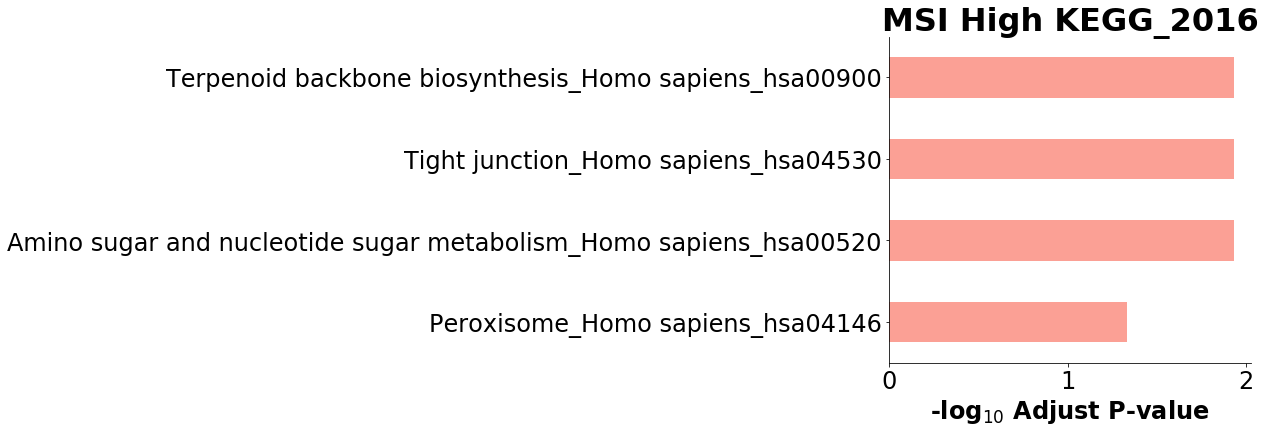

In [10]:
barplot(MSI_high_enr.res2d,title="MSI High KEGG_2016")

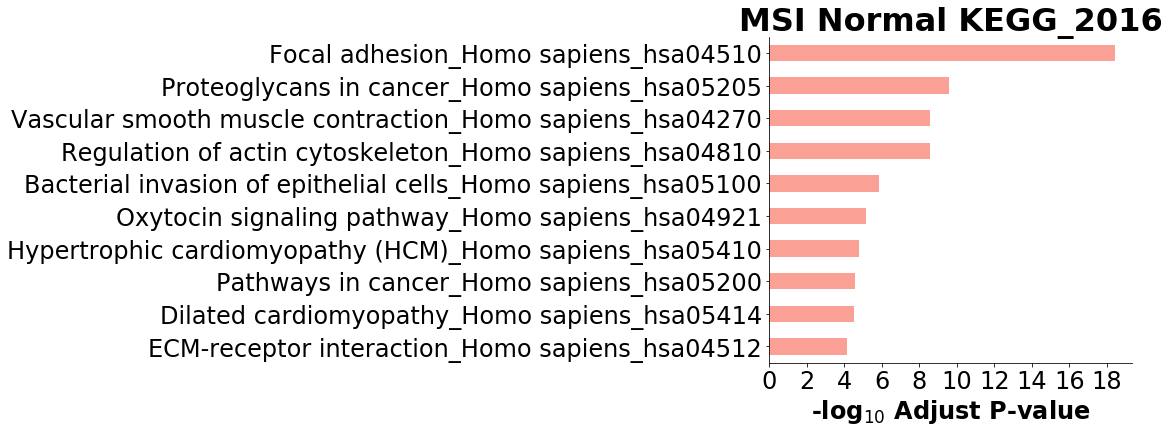

In [11]:
barplot(MSI_normal_enr.res2d,title="MSI Normal KEGG_2016")

## Discussion

When comparing these barplots, we can observe the MSI-high group has less pathways expressed at a less significant adjusted P-value than the MSI-normal group. This makes sense when we consider that MSI-high (microsatellite instability high) individuals have a less stable genome, thus resulting in less functional genes and less functional pathways, correlating with a high probability of cancer.